<center><h2>Projeto final de Machine Learning</h2></center>
<center><h3>Previsão de receita de filmes</h3></center>
<br />
<center>Alunos: Gabriela Caruso, Guilherme Roccato e Pedro Paulo Telho</center>



# Introdução

<p style="text-align: justify" align="justify">A indústria cinematográfica é reconhecida por suas diversas obras primas. Prêmios como Oscar, Globo de Ouro e Emmy são apenas alguns dos que recompensam os seus atores, diretores, produtores etc. Além disso, muito dinheiro é movimentado tanto em forma de investimento para a produção dos filmes como em forma de receita após o lançamento.</p>

<p style="text-align: justify" align="justify">Nesse contexto, o objetivo do projeto é prever quanto de receita um filme pode gerar para que não se tenha prejuízo durante suas produções.</p>
<p style="text-align: justify" align="justify">Para isso, será criado um modelo de regressão através da base de dados: <a href="https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2?select=tmdb_5000_movies.csv" >TMDb 5000 movies dataset</a></p>

# Metodologia

<p style="text-align: justify" align="justify">Nessa seção será apresentada a forma em que o modelo foi construído: bibliotecas necessárias, exploração dos dados e técnicas de inferência para definição do melhor modelo de machine learning para o problema.</p>

### Importando bibliotecas necessárias

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [142]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Carregando os dados

In [122]:
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

In [123]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Mesclando créditos e filmes

In [124]:
credits = credits[['movie_id', 'cast', 'crew']]
credits = credits.rename(columns = {'movie_id': 'id'})
movies = pd.merge(movies,credits,on='id',how='left')


In [125]:
movies_copy = movies.copy()

In [126]:
movies_copy.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Atenção

Inicialmente excluiremos as colunas que podem ser utilizadas para a análise de textos. O objetivo é começar uma análise simplificada e ir evoluindo com o progresso do projeto.

In [127]:
movies_copy = movies_copy.drop(columns={'homepage', 'id', 'keywords', 'original_title', 'overview', 'production_companies', 'tagline', 'cast', 'crew'})

### Exploração de dados

In [128]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 13 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
original_language       4803 non-null object
popularity              4803 non-null float64
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: float64(3), int64(3), object(7)
memory usage: 525.3+ KB


Como existem apenas 2 filmes sem 'runtime', ou seja, o tempo total de duração do filme, então, iremos retirar essas linhas.

In [129]:
movies_copy = movies_copy.dropna()

In [130]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4802
Data columns (total 13 columns):
budget                  4800 non-null int64
genres                  4800 non-null object
original_language       4800 non-null object
popularity              4800 non-null float64
production_countries    4800 non-null object
release_date            4800 non-null object
revenue                 4800 non-null int64
runtime                 4800 non-null float64
spoken_languages        4800 non-null object
status                  4800 non-null object
title                   4800 non-null object
vote_average            4800 non-null float64
vote_count              4800 non-null int64
dtypes: float64(3), int64(3), object(7)
memory usage: 525.0+ KB


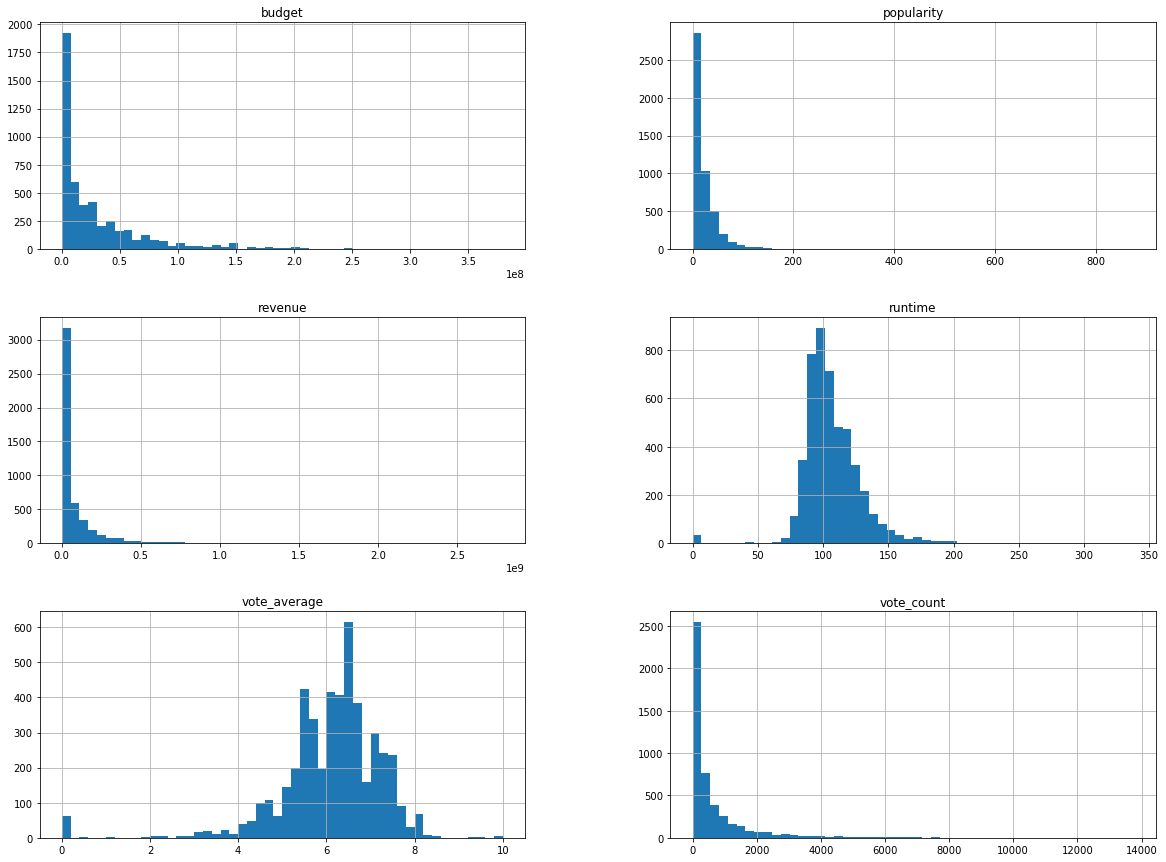

In [131]:
movies_copy.hist(bins=50, figsize=(20, 15))
plt.show()

Visualizando os histogramas acima é possível perceber que não há nenhuma anomalia com a base de dados e, portanto, é posssível continuar com a análise sem nenhuma necessidade de manipulação.

In [132]:
correlation_matrix = movies_copy.corr()

Com a matriz de correlação pode-se inferir também que a receita de cada filme tem maior correlação com a quantidade de votos (0.78)

In [133]:
correlation_matrix

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.505297,0.730781,0.269792,0.092224,0.593102
popularity,0.505297,1.000000,0.644654,0.225372,0.274212,0.778081
revenue,0.730781,0.644654,1.000000,0.251188,0.197291,0.781450
runtime,0.269792,0.225372,0.251188,1.000000,0.371888,0.272036
vote_average,0.092224,0.274212,0.197291,0.371888,1.000000,0.313693
vote_count,0.593102,0.778081,0.781450,0.272036,0.313693,1.000000


### Separação de dados treinamento/teste

Para mantermos a integridade dos dados de treinamento/teste é necessário fazer uma separação estratificada. Nesse sentido, será feita a separação pela variável vote_count.

In [134]:
movies_copy['vote_count'].max()

13752

In [135]:
movies_copy['vote_count'].min()

0

In [136]:
def stratified_shuffle(x):
    if x <= 2751:
        return 1.0
    elif x > 2751 and x <= 5502:
        return 2.0
    elif x > 5502 and x <= 8253:
        return 3.0
    elif x > 8253 and x <= 11004:
        return 4.0
    else:
        return 5.0

In [137]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].astype(int)

In [138]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].apply(stratified_shuffle)

In [140]:
movies_copy['vote_count_cat'].value_counts(True)

1.0    0.940000
2.0    0.045417
3.0    0.010625
4.0    0.003125
5.0    0.000833
Name: vote_count_cat, dtype: float64

In [144]:
# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(movies_copy, movies_copy['vote_count_cat']):
    strat_train_set = movies_copy.loc[train_index]
    strat_test_set = movies_copy.loc[test_index]

/tmp/ipykernel_172753/2783118421.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  strat_train_set = movies_copy.loc[train_index]


Verificando se a separação estratificada foi bem sucedida:

In [146]:
strat_train_set['vote_count_cat'].value_counts(True)

1.0    0.940318
2.0    0.044827
3.0    0.010946
4.0    0.003127
5.0    0.000782
Name: vote_count_cat, dtype: float64

In [147]:
strat_test_set['vote_count_cat'].value_counts(True)

1.0    0.938542
2.0    0.047917
3.0    0.009375
4.0    0.003125
5.0    0.001042
Name: vote_count_cat, dtype: float64

In [148]:
# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(['vote_count_cat'], axis=1, inplace=True)
strat_test_set.drop(['vote_count_cat'], axis=1, inplace=True)